In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum as sum_, to_timestamp
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler, StandardScaler
import matplotlib.pyplot as plt

In [3]:
spark = SparkSession.builder \
    .appName("Ecommerce Data EDA") \
    .getOrCreate()

print(f"Spark Version: {spark.version}")

Spark Version: 3.5.4


In [5]:
data_path = r"C:\Users\Vahe\ecommerce-data\data.csv"  
df = spark.read.csv(data_path, header=True, inferSchema=True)
df.show(5)
df.printSchema()

+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/2010 8:26|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
only showing top 5 rows

root
 |-- InvoiceNo: string (nullable = true)
 |

In [6]:
print(f"Number of rows: {df.count()}")
print(f"Number of columns: {len(df.columns)}")

Number of rows: 541909
Number of columns: 8


In [7]:
df = df.na.drop()  
df.describe().show()

+-------+------------------+------------------+--------------------+------------------+---------------+------------------+------------------+-----------+
|summary|         InvoiceNo|         StockCode|         Description|          Quantity|    InvoiceDate|         UnitPrice|        CustomerID|    Country|
+-------+------------------+------------------+--------------------+------------------+---------------+------------------+------------------+-----------+
|  count|            406829|            406829|              406829|            406829|         406829|            406829|            406829|     406829|
|   mean| 560617.1266447864|27430.341352504624|                NULL| 12.06130339774205|           NULL|3.4604710185376124|15287.690570239585|       NULL|
| stddev|13106.167694745218| 16403.57045262616|                NULL|248.69337001882533|           NULL| 69.31516172321422|1713.6003033215961|       NULL|
|    min|            536365|             10002| 4 PURPLE FLOCK D...|        

In [8]:
# Creating a temporary view to run SQL queries
df.createOrReplaceTempView("ecommerce_data")

# Query to get distinct countries
query = "SELECT DISTINCT Country FROM ecommerce_data"
result = spark.sql(query)
result.show()

+--------------------+
|             Country|
+--------------------+
|              Sweden|
|           Singapore|
|             Germany|
|              France|
|              Greece|
|             Belgium|
|             Finland|
|               Italy|
|                EIRE|
|           Lithuania|
|              Norway|
|               Spain|
|             Denmark|
|             Iceland|
|              Israel|
|     Channel Islands|
|              Cyprus|
|        Saudi Arabia|
|         Switzerland|
|United Arab Emirates|
+--------------------+
only showing top 20 rows



In [9]:
# Top 10 products by quantity sold
query = """
    SELECT StockCode, SUM(Quantity) AS TotalQuantitySold
    FROM ecommerce_data
    GROUP BY StockCode
    ORDER BY TotalQuantitySold DESC
"""
result = spark.sql(query)
result.show(10)

+---------+-----------------+
|StockCode|TotalQuantitySold|
+---------+-----------------+
|    84077|            53215|
|    22197|            48712|
|   85099B|            45066|
|    84879|            35314|
|   85123A|            34204|
|    21212|            33409|
|    23084|            27094|
|    22492|            25880|
|    22616|            25321|
|    21977|            24163|
+---------+-----------------+
only showing top 10 rows



In [10]:
# Top 10 descriptions by quantity sold

query = """
    SELECT Description, SUM(Quantity) AS TotalQuantitySold
    FROM ecommerce_data
    GROUP BY Description
    ORDER BY TotalQuantitySold DESC
    LIMIT 10
"""
result = spark.sql(query)
result.show(10)

+--------------------+-----------------+
|         Description|TotalQuantitySold|
+--------------------+-----------------+
|WORLD WAR 2 GLIDE...|            53215|
|JUMBO BAG RED RET...|            45066|
|ASSORTED COLOUR B...|            35314|
|WHITE HANGING HEA...|            34147|
|PACK OF 72 RETROS...|            33409|
|      POPCORN HOLDER|            30504|
|  RABBIT NIGHT LIGHT|            27094|
|MINI PAINT SET VI...|            25880|
|PACK OF 12 LONDON...|            25321|
|PACK OF 60 PINK P...|            24163|
+--------------------+-----------------+



In [11]:
# Change InvoiceDate to Date and Time format
df = df.withColumn("InvoiceDate", to_timestamp("InvoiceDate", "M/d/yyyy H:mm"))


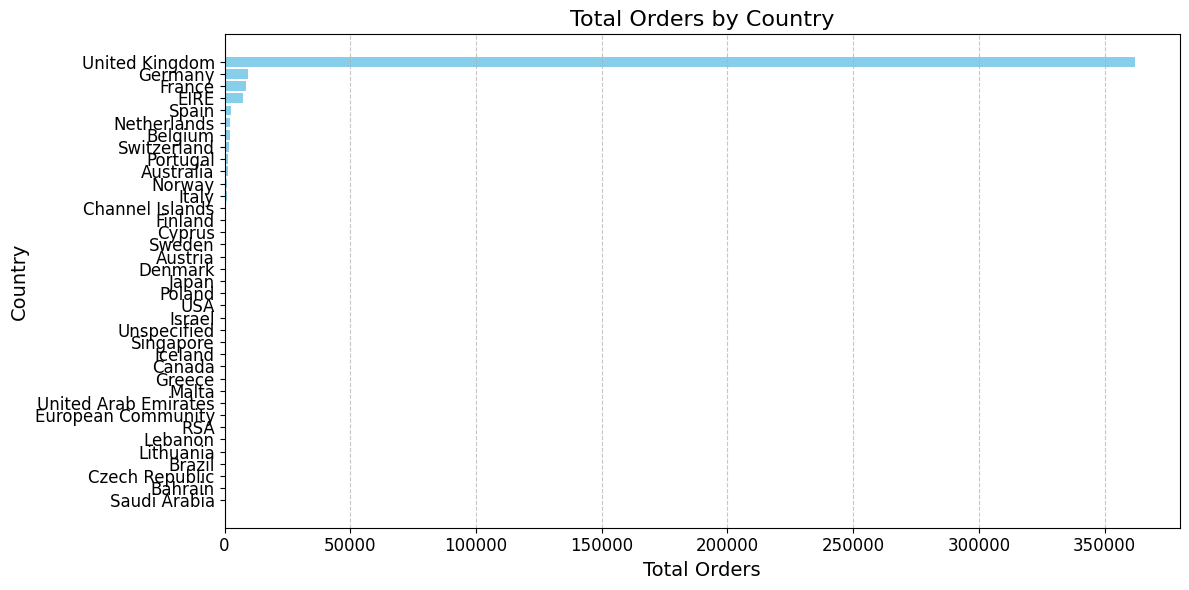

In [12]:
# Aggregated orders by country 
orders_by_country = spark.sql("SELECT Country, COUNT(InvoiceNo) AS TotalOrders FROM ecommerce_data GROUP BY Country ORDER BY TotalOrders DESC")
orders_by_country_pd = orders_by_country.toPandas()

plt.figure(figsize=(12, 6))
plt.barh(orders_by_country_pd['Country'], orders_by_country_pd['TotalOrders'], color='skyblue')
plt.xlabel('Total Orders', fontsize=14)
plt.ylabel('Country', fontsize=14)
plt.title('Total Orders by Country', fontsize=16)
plt.gca().invert_yaxis()  # Invert y-axis
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


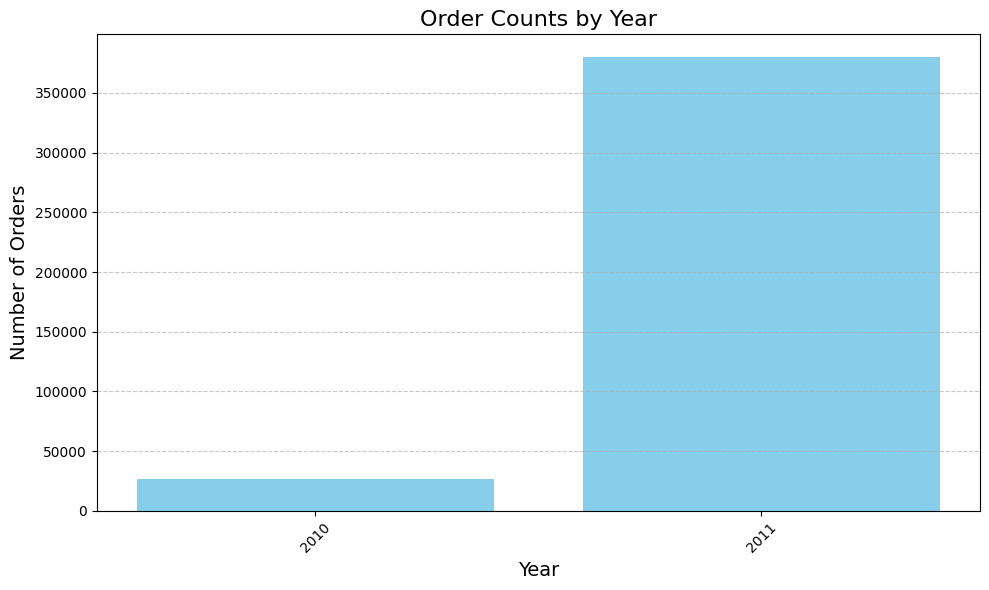

In [15]:
# Data grouped by Year and count the number of orders
df = df.withColumn("Year", col("InvoiceDate").substr(1, 4)) 
yearly_order_counts = df.groupBy("Year").count().orderBy("Year")
yearly_order_counts_pd = yearly_order_counts.toPandas()
plt.figure(figsize=(10, 6))
plt.bar(yearly_order_counts_pd["Year"], yearly_order_counts_pd["count"], color='skyblue')
plt.title("Order Counts by Year", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Number of Orders", fontsize=14)
plt.xticks(yearly_order_counts_pd["Year"], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [18]:
# Total spendings by Customers
df = df.withColumn("TotalSpent", col("Quantity") * col("UnitPrice"))
df_customer_spending = df.groupBy("CustomerID").agg(sum_("TotalSpent").alias("TotalSpent"))
df_customer_spending.show(5)


+----------+------------------+
|CustomerID|        TotalSpent|
+----------+------------------+
|     17420| 598.8299999999999|
|     16861|            151.65|
|     16503|           1421.43|
|     15727| 5178.959999999998|
|     17389|31300.079999999994|
+----------+------------------+
only showing top 5 rows



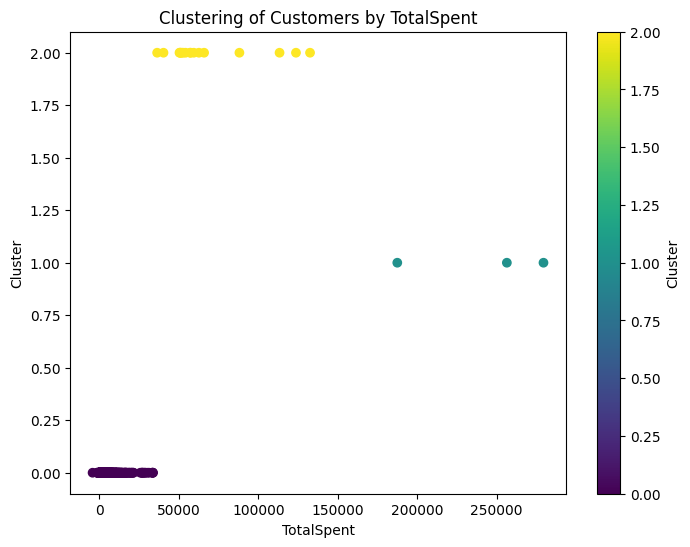

In [24]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler, StandardScaler
import matplotlib.pyplot as plt

#Checking if the 'features' column already exists, and drop it if so
if "features" in df_customer_spending.columns:
    df_customer_spending = df_customer_spending.drop("features")

#Creating a feature vector
assembler = VectorAssembler(inputCols=["TotalSpent"], outputCol="features")
df_customer_spending = assembler.transform(df_customer_spending)

#Checking if the 'scaledFeatures' column already exists, and drop it if so
if "scaledFeatures" in df_customer_spending.columns:
    df_customer_spending = df_customer_spending.drop("scaledFeatures")

#Scaling the features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
scaler_model = scaler.fit(df_customer_spending)
df_customer_spending = scaler_model.transform(df_customer_spending)

#Applying KMeans clustering
kmeans = KMeans(k=3, seed=1, featuresCol="scaledFeatures", predictionCol="prediction")
model = kmeans.fit(df_customer_spending)
predictions = model.transform(df_customer_spending)

# Converting to Pandas for visualization
total_spent = predictions.select("TotalSpent").toPandas().values.flatten()
predictions_values = predictions.select("prediction").toPandas().values.flatten()

# Visualisation
plt.figure(figsize=(8, 6))
plt.scatter(total_spent, predictions_values, c=predictions_values, cmap='viridis')
plt.xlabel("TotalSpent")
plt.ylabel("Cluster")
plt.title("Clustering of Customers by TotalSpent")
plt.colorbar(label='Cluster')
plt.show()

